In [1]:
import tensorflow as tf
keras = tf.keras
layers = keras.layers

import matplotlib.pyplot as plt
import numpy as np

## Load Data

In [2]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train = X_train.reshape(-1, 28, 28, 1) / 255.
X_test = X_test.reshape(-1, 28, 28, 1) / 255.
print(X_train.shape)

(60000, 28, 28, 1)


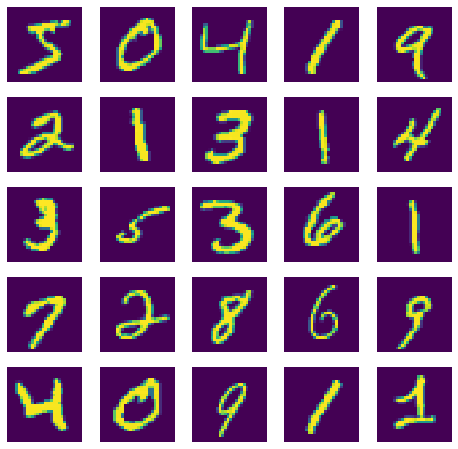

In [90]:
fig, axs = plt.subplots(5, 5, figsize=(8,8))
for i, ax in enumerate(axs.flat):
    ax.imshow(np.squeeze(X_train[i]))
    ax.axis('off')

## Basic Dense Autoencoder

In [19]:
# input
img_in = layers.Input(shape=X_train.shape[1:])
# encoding layer
encoding = layers.Flatten()(img_in)
encoding = layers.Dense(100)(encoding)
# decoding layer
decoding = layers.Dense(np.array(X_train.shape[1:]).prod())(encoding)
decoding = layers.Reshape(X_train.shape[1:])(decoding)

autoencoder = keras.Model(inputs=img_in, outputs=decoding)
encoder = keras.Model(inputs=img_in, outputs=encoding)

autoencoder.compile(loss=keras.losses.MSE, optimizer=keras.optimizers.Adam())

In [20]:
autoencoder.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_7 (Dense)              (None, 784)               79184     
_________________________________________________________________
reshape_3 (Reshape)          (None, 28, 28, 1)         0         
Total params: 157,684
Trainable params: 157,684
Non-trainable params: 0
_________________________________________________________________


In [20]:
autoencoder.fit(x=X_train, y=X_train, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 2s 892us/step - loss: 0.0121
Epoch 2/10
1875/1875 [==============================] - 2s 884us/step - loss: 0.0062
Epoch 3/10
1875/1875 [==============================] - 2s 876us/step - loss: 0.0061
Epoch 4/10
1875/1875 [==============================] - 2s 854us/step - loss: 0.0061
Epoch 5/10
1875/1875 [==============================] - 2s 878us/step - loss: 0.0060
Epoch 6/10
1875/1875 [==============================] - 2s 866us/step - loss: 0.0060
Epoch 7/10
1875/1875 [==============================] - 2s 878us/step - loss: 0.0060
Epoch 8/10
1875/1875 [==============================] - 2s 887us/step - loss: 0.0060
Epoch 9/10
1875/1875 [==============================] - 2s 877us/step - loss: 0.0060
Epoch 10/10
1875/1875 [==============================] - 2s 906us/step - loss: 0.0060


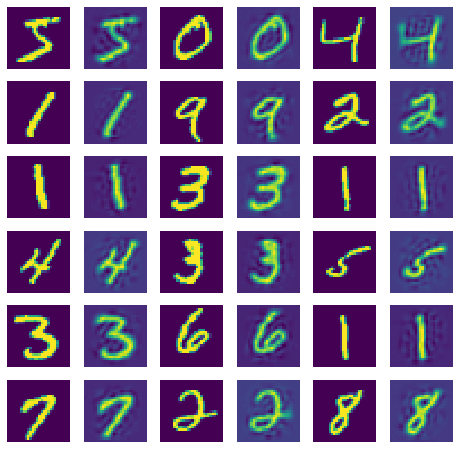

In [24]:
X_pred = autoencoder.predict(x=X_train[:25])
fig, axs = plt.subplots(6, 6, figsize=(8,8))
for i, ax in enumerate(axs.flat):
    if i%2 == 0:
        ax.imshow(np.squeeze(X_train[int(i/2)]))
    else:
        ax.imshow(np.squeeze(X_pred[int(i/2)]))
    ax.axis('off')

## Convolutional autoencoder

### tanh

In [108]:
# reset graph
keras.backend.clear_session()
activation = 'tanh'

# input
print(X_train.shape[1:])
img_in = layers.Input(shape=X_train.shape[1:])

# encoding layer
encoding = layers.Conv2D(filters=20, kernel_size=5, activation=activation)(img_in) # 24x24
encoding = layers.MaxPool2D()(encoding) # 12x12
encoding = layers.Conv2D(filters=40, kernel_size=5, activation=activation)(encoding) # 8x8
encoding = layers.MaxPool2D()(encoding) # 4x4
encoding = layers.Conv2D(filters=3, kernel_size=3, activation=activation, padding='same')(encoding) # 4x4x3

# latent
latent = layers.Flatten()(encoding)
print("Latent space shape: ", latent.shape)

# decoder
decoder_in = layers.Input(shape=latent.shape)
decoder_layers = []
decoder_layers.append(layers.Reshape(encoding.shape[1:]))
decoder_layers.append(layers.UpSampling2D()) # 8x8x8
decoder_layers.append(layers.Conv2D(filters=40, kernel_size=5, activation=activation, padding="same")) # 8x8x20
decoder_layers.append(layers.UpSampling2D()) # 16x16x20
decoder_layers.append(layers.Conv2D(filters=20, kernel_size=5, activation=activation, padding="same")) # 16x16x20
decoder_layers.append(layers.UpSampling2D())
decoder_layers.append(layers.Conv2D(filters=1, kernel_size=5, activation='sigmoid'))

def decode(layer_in):
    result = layer_in
    for decoder in decoder_layers:
        result = decoder(result)
    return result

conv_autoencoder = keras.Model(inputs=img_in, outputs=decode(latent))
conv_encoder = keras.Model(inputs=img_in, outputs=latent)
conv_decoder = keras.Model(inputs=decoder_in, outputs=decode(decoder_in))

conv_autoencoder.compile(loss=keras.losses.MSE, optimizer=keras.optimizers.Adam())
print()
conv_autoencoder.summary()

(28, 28, 1)
Latent space shape:  (None, 48)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 24, 24, 20)        520       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 20)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 40)          20040     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 40)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 3)           1083      
_________________________________________________________________
flatten (Flatten

In [109]:
conv_autoencoder.fit(x=X_train, y=X_train, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0284
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0145
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0118
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0103
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0094
Epoch 6/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0086
Epoch 7/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0081
Epoch 8/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0077
Epoch 9/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0074
Epoch 10/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0071


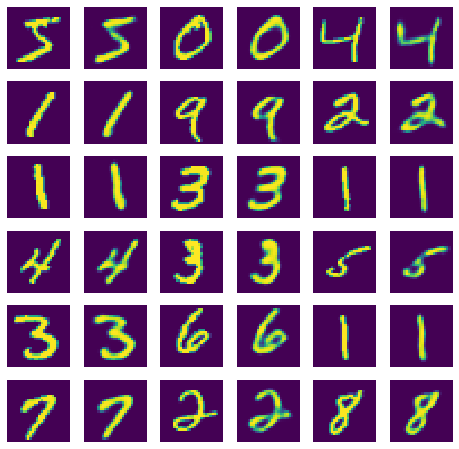

In [82]:
X_pred = conv_autoencoder.predict(x=X_train[:25])
fig, axs = plt.subplots(6, 6, figsize=(8,8))
for i, ax in enumerate(axs.flat):
    if i%2 == 0:
        ax.imshow(np.squeeze(X_train[int(i/2)]))
    else:
        ax.imshow(np.squeeze(X_pred[int(i/2)]))
    ax.axis('off')

In [111]:
# reset graph
keras.backend.clear_session()
activation = 'relu'

# input
print(X_train.shape[1:])
img_in = layers.Input(shape=X_train.shape[1:])

# encoding layer
encoding = layers.Conv2D(filters=20, kernel_size=5, activation=activation)(img_in) # 24x24
encoding = layers.BatchNormalization()(encoding)
encoding = layers.MaxPool2D()(encoding) # 12x12
encoding = layers.Conv2D(filters=40, kernel_size=5, activation=activation)(encoding) # 8x8
encoding = layers.BatchNormalization()(encoding)
encoding = layers.MaxPool2D()(encoding) # 4x4
encoding = layers.Conv2D(filters=3, kernel_size=3, activation=activation, padding='same')(encoding) # 4x4x3
encoding = layers.BatchNormalization()(encoding)

# latent
latent = layers.Flatten()(encoding)
print("Latent space shape: ", latent.shape)

# decoder
decoder_in = layers.Input(shape=latent.shape)
decoder_layers = []
decoder_layers.append(layers.Reshape(encoding.shape[1:]))
decoder_layers.append(layers.UpSampling2D()) # 8x8x8
decoder_layers.append(layers.Conv2D(filters=40, kernel_size=5, activation=activation, padding="same")) # 8x8x20
decoder_layers.append(layers.BatchNormalization())
decoder_layers.append(layers.UpSampling2D()) # 16x16x20
decoder_layers.append(layers.Conv2D(filters=20, kernel_size=5, activation=activation, padding="same")) # 16x16x20
decoder_layers.append(layers.BatchNormalization())
decoder_layers.append(layers.UpSampling2D())
decoder_layers.append(layers.Conv2D(filters=1, kernel_size=5, activation='sigmoid'))

def decode(layer_in):
    result = layer_in
    for decoder in decoder_layers:
        result = decoder(result)
    return result

conv_bn_autoencoder = keras.Model(inputs=img_in, outputs=decode(latent))
conv_bn_encoder = keras.Model(inputs=img_in, outputs=latent)
conv_bn_decoder = keras.Model(inputs=decoder_in, outputs=decode(decoder_in))

conv_bn_autoencoder.compile(loss=keras.losses.MSE, optimizer=keras.optimizers.Adam())
print()
conv_bn_autoencoder.summary()

(28, 28, 1)
Latent space shape:  (None, 48)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 24, 24, 20)        520       
_________________________________________________________________
batch_normalization (BatchNo (None, 24, 24, 20)        80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 20)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 40)          20040     
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 40)          160       
_________________________________________________________________
max_pooling2d_1 

In [113]:
conv_bn_autoencoder.fit(x=X_train, y=X_train, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0177
Epoch 2/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0089
Epoch 3/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0076
Epoch 4/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0070
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0066
Epoch 6/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0063
Epoch 7/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0061
Epoch 8/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0059
Epoch 9/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0058
Epoch 10/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0057


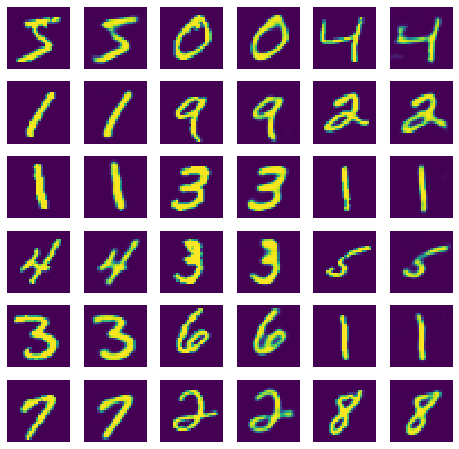

In [114]:
X_pred = conv_bn_autoencoder.predict(x=X_train[:25])
fig, axs = plt.subplots(6, 6, figsize=(8,8))
for i, ax in enumerate(axs.flat):
    if i%2 == 0:
        ax.imshow(np.squeeze(X_train[int(i/2)]))
    else:
        ax.imshow(np.squeeze(X_pred[int(i/2)]))
    ax.axis('off')

## blend embeddings

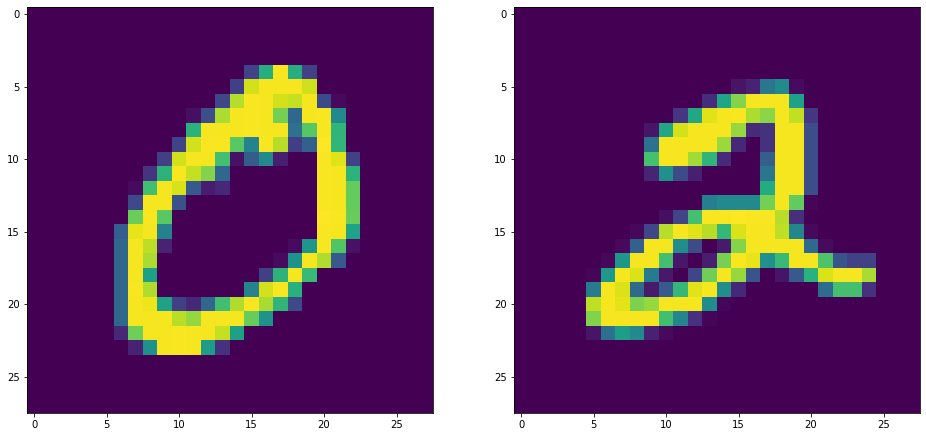

In [128]:
# let's turn a "0" into a "2"
first_0 = X_train[1]
first_2 = X_train[5]

# plot these
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
axs[0].imshow(np.squeeze(first_0))
axs[1].imshow(np.squeeze(first_2))

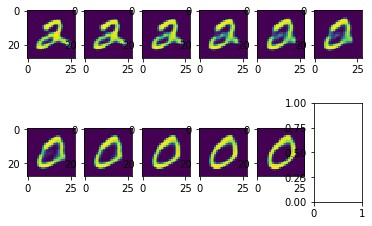

In [144]:
# calculate embeddings
latent_preds = conv_bn_encoder(X_train[:25])
first_0_latent = latent_preds[1]
first_2_latent = latent_preds[5]

# linearly interpolate between embeddings
embeds = np.zeros((11, first_0_latent.shape[0]))
for i in range(0, 11):
    factor = i * .1
    embeds[i] = factor * first_0_latent + (1-factor) * first_2_latent
    
# decode to images
decoded_embeddings = conv_bn_decoder.predict(embeds)

from math import ceil
fig, axs = plt.subplots(2, ceil(len(decoded_embeddings)/2))
for i, ax in enumerate(axs.flat):
    if i == len(decoded_embeddings):
        break
    ax.imshow(np.squeeze(decoded_embeddings[i]))

# with self-attention

https://medium.com/lsc-psd/introduction-of-self-attention-layer-in-transformer-fc7bff63f3bc

https://pretteyandnerdy.wordpress.com/2019/04/26/attention-is-all-you-need/

https://datascience.stackexchange.com/questions/76444/how-can-i-build-a-self-attention-model-with-tf-keras-layers-attention

https://www.tensorflow.org/tutorials/text/transformer

In [3]:
fake_samples = np.random.rand(10, 28, 28, 3)

In [5]:
class SelfAttention(layers.Layer):
    def __init__(self, kqv_size):
        super(SelfAttention, self).__init__()
        if isinstance(kqv_size, int):
            self.kqv_size = (kqv_size, kqv_size, kqv_size)
        elif (
            len(kqv_size) == 3 and all(isinstance(i, int) for i in kqv_size)
            and kqv_size[0] == kqv_size[1]
        ):
            self.kqv_size = kqv_size
        else:
            raise ValueError("Invalid kqv_size given - should be int or (int, int, int)")

    def build(self, input_shape): # say input_shape is (batch_size, 28*28, 3)
        input_len, input_features = input_shape[-2:]
        # "Key" weight matrix and biases
        self.Wk = self.add_weight("Wk", shape=[input_features, self.kqv_size[0]])
        self.Bk = self.add_weight("Bk", shape=[self.kqv_size[0]])
        # ditto "Query"
        self.Wq = self.add_weight("Wq", shape=[input_features, self.kqv_size[1]])
        self.Bq = self.add_weight("Bq", shape=[self.kqv_size[1]])
        # ditto "Value"
        self.Wv = self.add_weight("Wv", shape=[input_features, self.kqv_size[2]])
        self.Bv = self.add_weight("Bv", shape=[self.kqv_size[2]])
        
    def call(self, input):
        # calculate K, Q and V
        k = tf.einsum('...sf,fK->...sK', input, self.Wk) + self.Bk
        q = tf.einsum('...sf,fQ->...sQ', input, self.Wq) + self.Bq 
        v = tf.einsum('...sf,fV->...sV', input, self.Wv) + self.Bv
        # calculate attention scores for each input element: Q K.T
        # dim batch_size * seq_len * seq_len
        attn_scores = tf.einsum('...iD,...jD->...ij', k, q)
        # softmax attention scores
        sm_attn_scores = layers.Softmax(axis=-1)(attn_scores)
        # calculate "weighted values" (aka "alignment vectors") and sum over 
        # all the other elements
        sum_weighted_vals = tf.einsum('...ij,...jV->...iV', sm_attn_scores, v)
        # calculated outputs: the element-wise sum of the weighted values 
        #outs = tf.reduce_sum(weighted_vals, axis=)
        return sum_weighted_vals

In [6]:
sa = SelfAttention(kqv_size=(5,5,4))

In [7]:
fsr = fake_samples.reshape(10, -1, 3)
k = sa(fsr)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [10]:
fsr.shape, k.shape

((10, 784, 3), TensorShape([10, 784, 4]))

In [102]:
X_train.shape[1:]

(28, 28, 1)

In [101]:
encoding

<tf.Tensor 'flatten_1/Identity:0' shape=(None, 784) dtype=float32>

In [3]:
layers.ReLU

tensorflow.python.keras.layers.advanced_activations.ReLU

In [ ]:
encoding = SelfAttention(1)(encoding)

In [21]:
# input
img_in = layers.Input(shape=X_train.shape[1:])

# encoding layer
encoding = layers.Flatten()(img_in)
encoding = SelfAttention(1)(encoding)
encoding = layers.ReLU()(encoding)
encoding = layers.Dense(100, activation='relu')(encoding)
# decoding layer
decoding = SelfAttention(2)(encoding)
decoding = layers.Dense(np.array(X_train.shape[1:]).prod())(decoding)
decoding = layers.Reshape(X_train.shape[1:])(decoding)

autoencoder = keras.Model(inputs=img_in, outputs=decoding)
encoder = keras.Model(inputs=img_in, outputs=encoding)

autoencoder.compile(loss=keras.losses.MSE, optimizer=keras.optimizers.Adam())

In [22]:
autoencoder.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
self_attention_7 (SelfAttent (None, 2)                 4710      
_________________________________________________________________
dense_8 (Dense)              (None, 100)               300       
_________________________________________________________________
self_attention_8 (SelfAttent (None, 2)                 606       
_________________________________________________________________
dense_9 (Dense)              (None, 784)               2352      
_________________________________________________________________
reshape_4 (Reshape)          (None, 28, 28, 1)         0   

In [23]:
autoencoder.fit(x=X_train, y=X_train, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0652
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0601
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0594
Epoch 4/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0592
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0591
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0590
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0588
Epoch 8/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0587
Epoch 9/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0586
Epoch 10/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0586


In [107]:
32*28*28*784

19668992